# Build HDF5 Container Input for GCN from Methylation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
plt.rc('font', family='Times New Roman')
import h5py
import seaborn as sns
import os, sys

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Parameters

In [2]:
USE_BATCH_CORRECTED = True

## 1. Load Methylation Matrices & Compute Fold Changes

In [3]:
def get_foldchanges(tumor_sample_path, normal_sample_path):
    tumor_samples = pd.read_csv(tumor_sample_path, sep='\t')
    normal_samples = pd.read_csv(normal_sample_path, sep='\t')

    # restore the column names for samples
    tumor_samples.columns = ['-'.join(i.split('.')[:7]) + '|' + i.split('.')[7] + '|' + i.split('.')[8] for i in tumor_samples.columns]
    normal_samples.columns = ['-'.join(i.split('.')[:7]) + '|' + i.split('.')[7] + '|' + i.split('.')[8] for i in normal_samples.columns]

    # make it the same genes for both dataframes and verify
    common_genes = tumor_samples.index.intersection(normal_samples.index)
    tumor_samples = tumor_samples.reindex(common_genes)
    normal_samples = normal_samples.reindex(common_genes)
    assert ((normal_samples.index == tumor_samples.index).all())

    # compute log2 fold changes (for each sample, divide by mean normal values. Then compute mean across samples)
    fc = np.log2(tumor_samples.divide(normal_samples.mean(axis=1), axis=0))
    fc_nan = fc.replace([np.inf, -np.inf], np.nan)
    print ("Got {} invalid values after computing log2 fold changes".format(fc_nan.isnull().sum().sum()))
    fc = fc_nan.dropna(axis=0) # remove NaN and inf (from division by 0 or 0+eta)

    return fc

base_dir = '../../data/pancancer/TCGA/methylation/gene_sample_matrices_cancertype/'

if USE_BATCH_CORRECTED:
    fname = '{}_samples.adjusted.tsv'
else:
    fname = '{}_samples.tsv'

all_foldchanges = []
for ctype in os.listdir(base_dir):
    ctype_dir = os.path.join(base_dir, ctype)
    if os.path.isdir(ctype_dir) and not ctype == 'OV': # don't have normals for OV
        fc = get_foldchanges(os.path.join(ctype_dir, fname.format('tumor')),
                             os.path.join(ctype_dir, fname.format('normal'))
                            )
        all_foldchanges.append(fc)
        print ("Processed {}".format(ctype))

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log2


Got 5096 invalid values after computing log2 fold changes
Processed UCEC
Got 3028 invalid values after computing log2 fold changes
Processed HNSC
Got 1109 invalid values after computing log2 fold changes
Processed LUAD
Got 1403 invalid values after computing log2 fold changes
Processed KIRP
Got 3479 invalid values after computing log2 fold changes
Processed KIRC
Got 1303 invalid values after computing log2 fold changes
Processed PRAD
Got 3648 invalid values after computing log2 fold changes
Processed COAD
Got 1790 invalid values after computing log2 fold changes
Processed GBM
Got 1840 invalid values after computing log2 fold changes
Processed LUSC
Got 2912 invalid values after computing log2 fold changes
Processed CESC
Got 2741 invalid values after computing log2 fold changes
Processed SARC
Got 5903 invalid values after computing log2 fold changes
Processed STAD
Got 4764 invalid values after computing log2 fold changes
Processed BRCA
Got 5862 invalid values after computing log2 fold ch

In [4]:
meth_all_samples = all_foldchanges[0].join(all_foldchanges[1:]).dropna(axis=0)
meth_all_samples.head()

,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-FI-A2D5-01A-11D-A17F-05|ucec|mean_beta_value_promoter,TCGA-EY-A1G8-01A-11D-A13K-05|ucec|mean_beta_value_promoter,TCGA-AX-A1CR-01A-12D-A138-05|ucec|mean_beta_value_promoter,TCGA-AJ-A6NU-01A-11D-A34S-05|ucec|mean_beta_value_promoter,TCGA-BG-A221-01A-21D-A161-05|ucec|mean_beta_value_promoter,TCGA-EY-A1GQ-01A-21D-A13K-05|ucec|mean_beta_value_promoter,TCGA-EY-A214-01A-12D-A161-05|ucec|mean_beta_value_promoter,TCGA-AX-A06D-01A-11D-A123-05|ucec|mean_beta_value_promoter,TCGA-D1-A102-01A-11D-A10N-05|ucec|mean_beta_value_promoter,...,TCGA-2J-AAB9-01A-11D-A40Y-05|paad|mean_beta_value_promoter,TCGA-FB-A4P6-01A-12D-A26Q-05|paad|mean_beta_value_promoter,TCGA-HV-A5A3-01A-11D-A26Q-05|paad|mean_beta_value_promoter,TCGA-FB-AAPU-01A-31D-A40Y-05|paad|mean_beta_value_promoter,TCGA-IB-AAUT-01A-11D-A378-05|paad|mean_beta_value_promoter,TCGA-YH-A8SY-01A-11D-A378-05|paad|mean_beta_value_promoter,TCGA-2L-AAQE-01A-11D-A398-05|paad|mean_beta_value_promoter,TCGA-HV-A5A4-01A-11D-A26Q-05|paad|mean_beta_value_promoter,TCGA-HZ-A4BK-01A-11D-A26Q-05|paad|mean_beta_value_promoter,TCGA-IB-7893-01A-11D-2202-05|paad|mean_beta_value_promoter
A1BG,-0.798366,-0.383766,-1.049645,0.214407,-0.302838,0.164426,-0.737405,-0.104006,0.354586,-0.640847,...,-0.042188,0.137356,0.155170,0.069753,-0.113756,-0.189510,0.119348,0.252318,-0.104668,-0.156267
A2ML1,-0.883624,-0.766584,-0.924846,-1.057997,-0.143333,-0.056973,-0.761385,-0.197348,-0.319177,-0.639808,...,-0.160109,-0.026153,-1.128142,-0.728953,-0.065089,-0.627074,-0.631772,-0.117794,-0.254853,-0.357015
A4GNT,0.046651,-0.168577,0.168144,0.101487,-0.150446,-0.096889,-0.097417,-0.488444,0.068507,-0.320073,...,-0.155132,-0.291773,-0.174671,-0.701415,-0.139667,0.159339,-0.126039,-0.385403,-0.268851,0.140066
AACS,-0.109783,-0.530839,0.107899,0.069633,-0.040909,0.762690,0.341024,-0.068694,0.965406,-0.005546,...,0.156880,0.232888,-0.220497,-0.211224,0.263638,0.066465,0.020745,-0.247775,-0.128325,-0.017831
AADAC,-0.054747,-0.015426,0.025275,-0.042065,-0.017240,-0.029030,-0.033186,-0.030810,0.057011,-0.018536,...,-0.043026,0.030038,-0.515393,-0.641033,-0.004259,-0.193514,-0.186742,-0.312615,-0.174800,0.046650


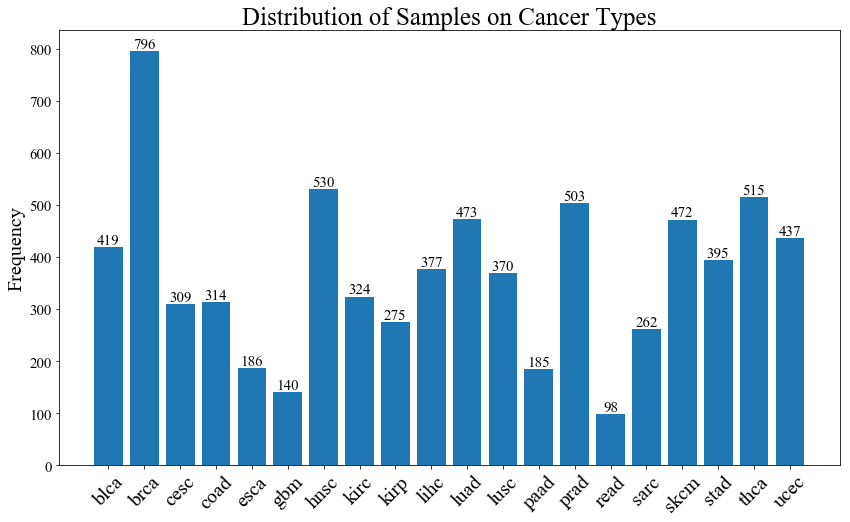

In [5]:
c_types = [n.split('|')[1] for n in meth_all_samples.columns[1:] if "mean_beta_value_promoter" in n]
unique, counts = np.unique(c_types, return_counts=True)
fig = plt.figure(figsize=(14, 8))
b = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)

# Add counts above the two bar graphs
for rect in b:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', size=15)

fig.savefig('../../data/pancancer/TCGA/methylation/samples_per_cancertype.svg')

## 2. Mean Samples Across Cancer Types

In [6]:
# first, transpose and add column with cancer type
meth_t = meth_all_samples.T
meth_t['cancer_type'] = [i[1] for i in meth_t.index.str.split('|')]

# compute mean across all cancer types
meth_mean = meth_t.fillna(0).groupby('cancer_type').mean().T
meth_mean.head()

cancer_type,blca,brca,cesc,coad,esca,gbm,hnsc,kirc,kirp,lihc,luad,lusc,paad,prad,read,sarc,skcm,stad,thca,ucec
A1BG,-0.520220,0.009646,0.014614,-0.273176,-0.032555,-0.037841,-0.102763,-0.031303,0.167544,-0.299437,0.025191,-0.061336,0.048122,-0.077949,-0.477317,-0.129935,-0.008300,-0.351716,0.025845,-0.257754
A2ML1,-0.974060,-0.157263,-1.010543,-0.424749,-0.623844,-0.054086,-0.322204,-0.068583,0.011582,-0.635875,-0.199836,-0.752311,-0.312557,0.001978,-0.631794,0.128722,-0.034205,-0.371718,-0.034067,-0.408135
A4GNT,-0.600173,-0.281311,-0.640089,-0.625206,0.095356,-0.470759,-0.563481,-0.138225,-0.099148,-0.389381,-0.205944,-0.509515,-0.176104,-0.061149,-0.853789,-0.271265,-0.004964,0.492356,-0.018352,-0.263875
AACS,-0.285123,-0.245023,0.098228,0.138513,0.092186,0.056055,-0.045437,-0.163034,-0.343752,-0.351060,-0.290564,-0.331682,0.052270,-0.170611,-0.190099,0.093569,0.392894,-0.026524,-0.119981,0.098013
AADAC,-0.179499,-0.028271,-0.060307,-0.045163,-0.051730,-0.072009,-0.050299,-0.025501,-0.029176,-0.190502,0.001536,-0.114830,-0.156746,-0.054244,-0.042610,-0.129589,-0.088350,-0.155280,-0.004042,-0.039665


/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


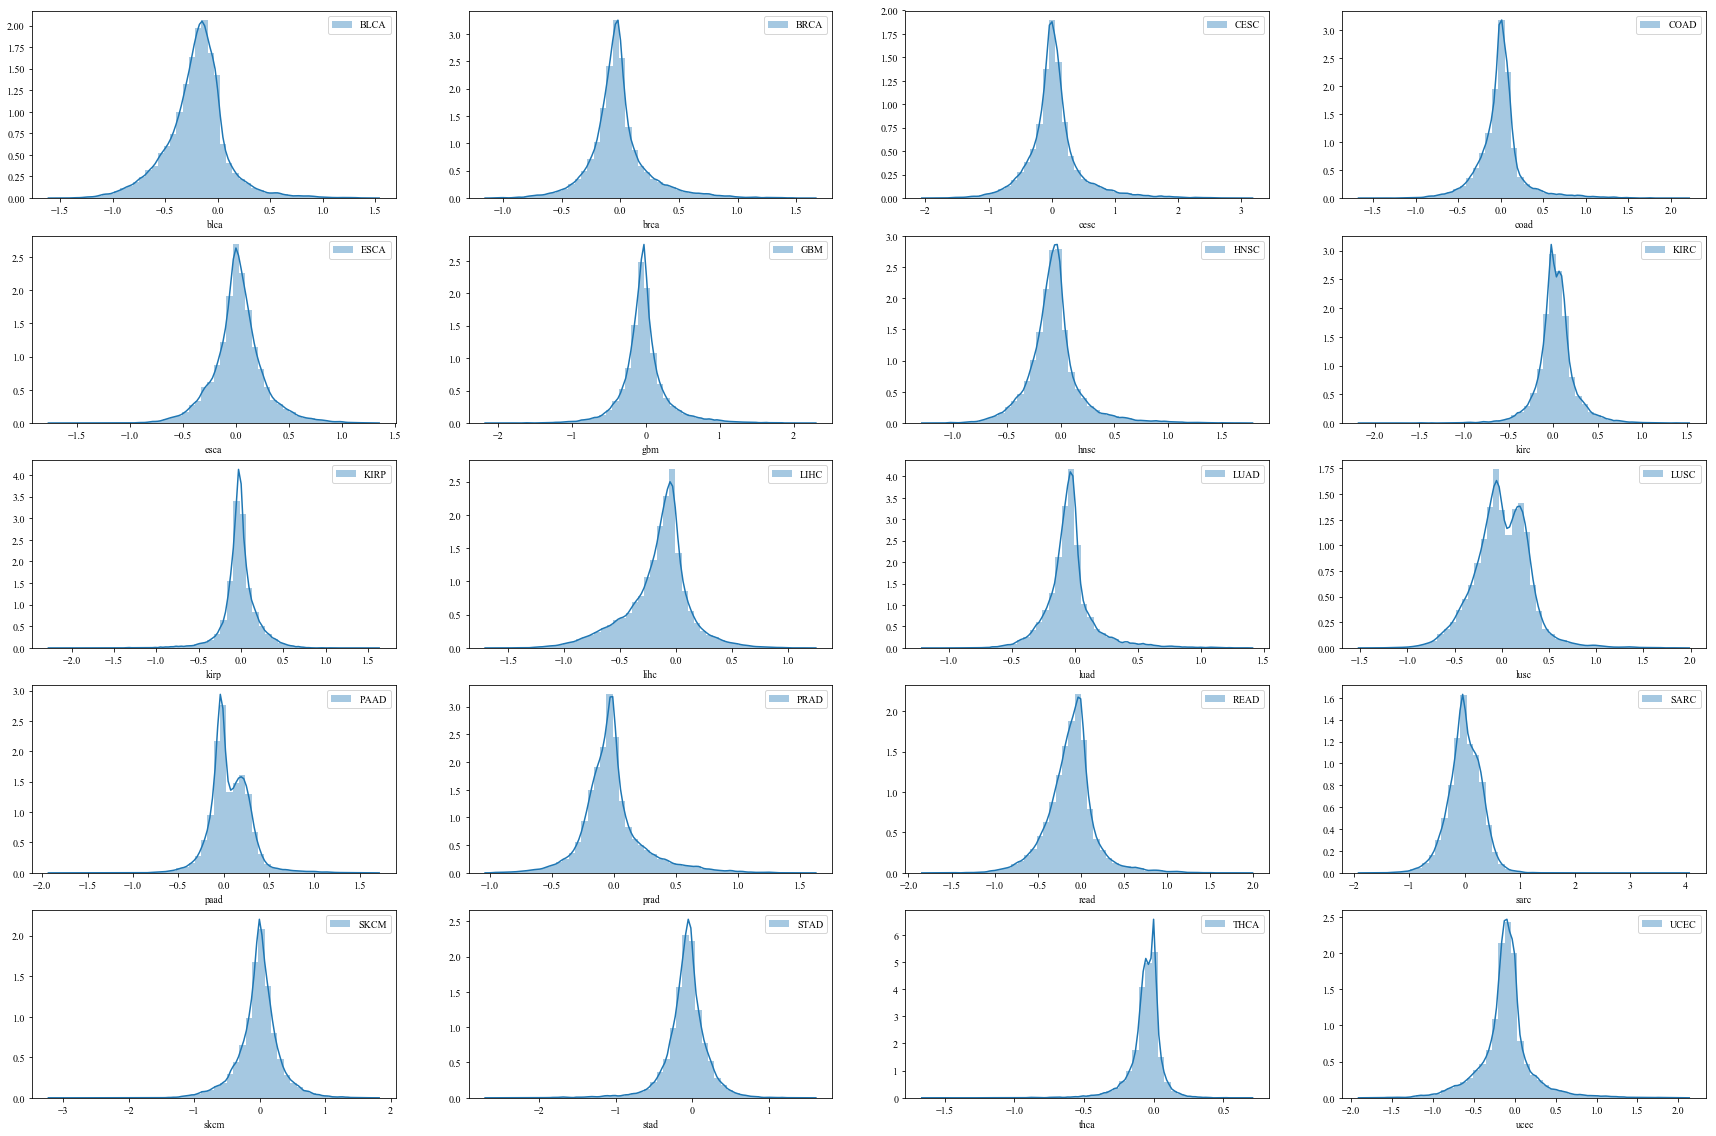

In [17]:
# convert to long format
fig = plt.figure(figsize=(30, 20))
count = 1
for col in meth_mean.columns:
    plt.subplot(5, 4, count)
    sns.distplot(meth_mean[col], label=col.upper(), hist=True)
    count += 1
    plt.legend()
    #plt.gca().set_xlim([-1, 1])
fig.savefig('../../data/pancancer/TCGA/methylation/distribution_fc_cancertypes.png', dpi=300)

## 3. Check Methylation for Oncogenes & Tumor Suppressors

Got 125 cancer genes
Other       21389
TSG            53
Oncogene       35
Name: type, dtype: int64


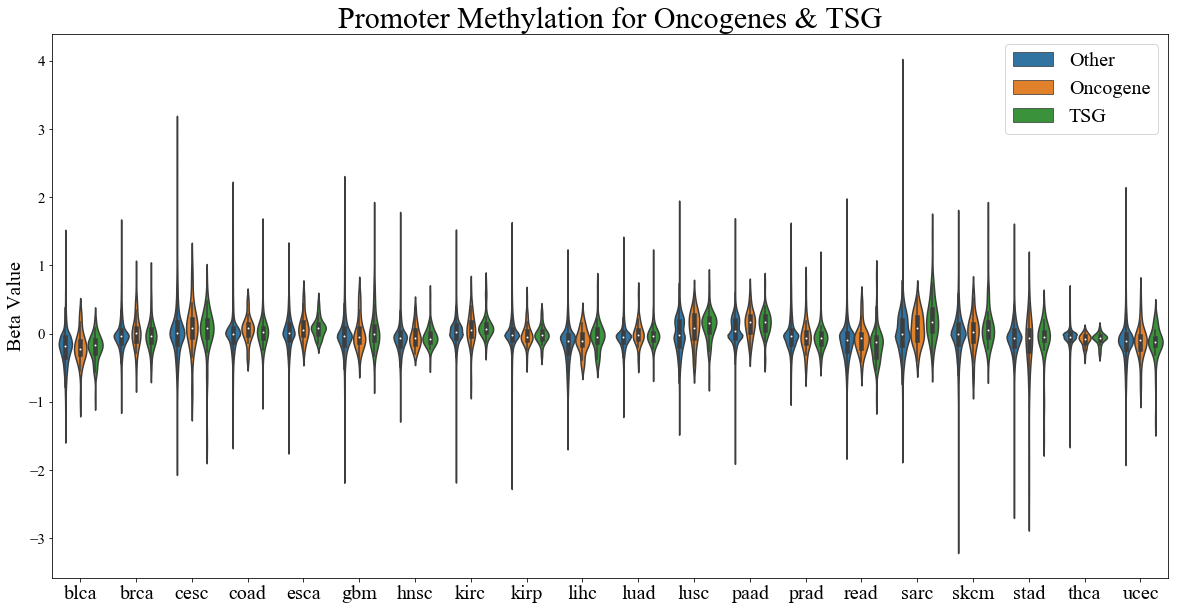

In [18]:
cancer_genes = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
cancer_genes.columns = [i.strip('*') for i in cancer_genes.columns]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} cancer genes".format(cancer_genes.shape[0]))

meth_mean_onco = meth_mean
meth_mean_onco.drop('kind', axis=1, inplace=True, errors='ignore')
meth_mean_onco['type'] = 'Other'
meth_mean_onco.loc[meth_mean_onco.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
meth_mean_onco.loc[meth_mean_onco.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
print (meth_mean_onco.type.value_counts())

# plot
fig = plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=pd.melt(meth_mean_onco, id_vars=['type']),
                        x='cancer_type',
                        y='value',
                        hue='type',
                        dodge=True,
                        scale_hue=True
                       )
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.svg')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.png', dpi=300)

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


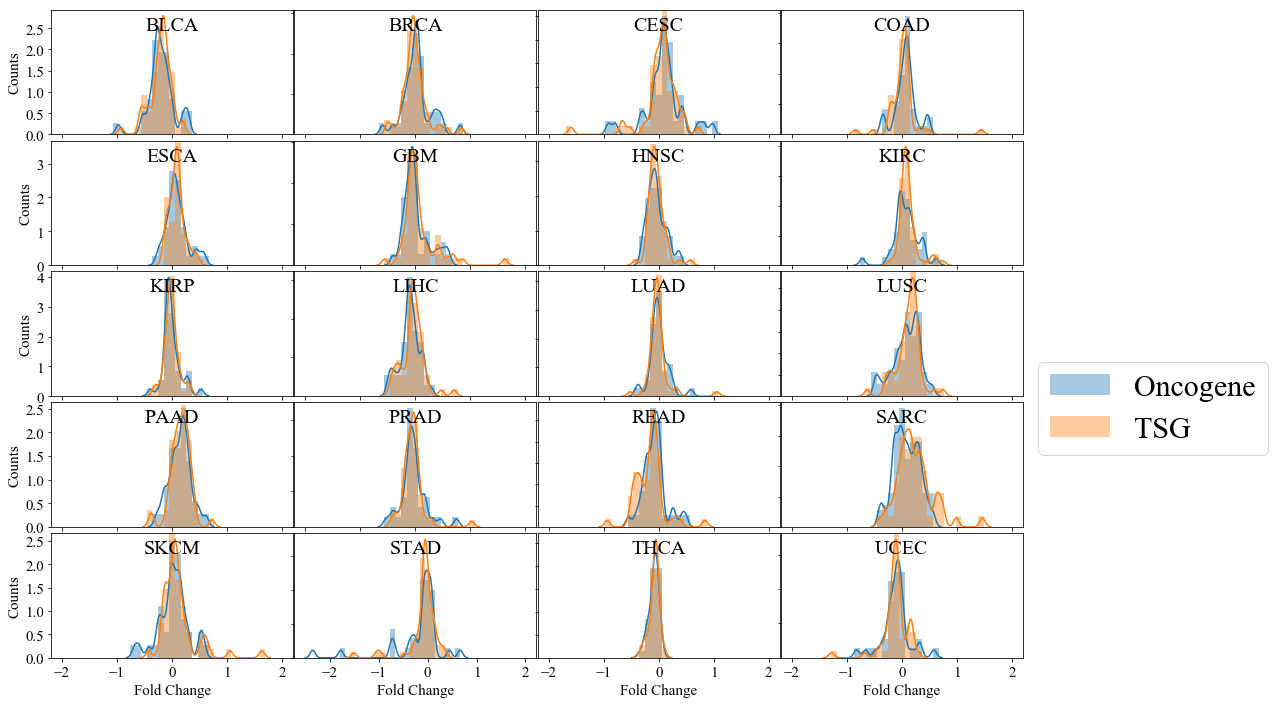

In [19]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(5, 4, width_ratios=[1, 1, 1, 1],
         wspace=0.005, hspace=0.05, top=0.95, bottom=0.05, left=0.17, right=0.845)

count = 1
bins = np.linspace(-2, 2, 40)
for ctype in meth_mean_onco.columns[:-1]:
    plt.subplot(gs[count-1])
    sns.distplot(a=meth_mean_onco.loc[meth_mean_onco.type == 'Oncogene', ctype],
                 label='Oncogene', kde=True, bins=bins, hist_kws={'alpha':0.4}, kde_kws={'bw':0.05})
    sns.distplot(a=meth_mean_onco.loc[meth_mean_onco.type == 'TSG', ctype],
                 label='TSG', kde=True, bins=bins, hist_kws={'alpha':0.4}, kde_kws={'bw':0.05})
    #sns.kdeplot(data=meth_prom_mean.loc[meth_prom_mean.type == 'Other', ctype], label='Other', kde=True,
    #             hist_kws={"alpha": .1, "color": "g"}, kde_kws={'alpha':0.3}
    #            )
    plt.title(ctype.upper(), pad=-20, size=20)
    #plt.ylim([0, 1])
    #plt.xlim([-0.05, 1.05])
    if (count-1) % 4 == 0:
        plt.ylabel('Counts', fontsize=15)
        plt.setp(plt.gca().get_yticklabels(), size=15)
    else:
        plt.ylabel('')
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    if count in [17, 18, 19, 20]:
        plt.xlabel('Fold Change', fontsize=15)
        plt.setp(plt.gca().get_xticklabels(), size=15)
    else:
        plt.xlabel('')
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        #plt.setp(plt.gca().get_yticklabels(), visible=False)
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 2), fontsize=30)
#plt.title('DNA Methylation Across Cancer Types', fontsize=30, loc='Center')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_histograms.svg')

In [20]:
s = meth_mean.brca.idxmax()
meth_mean['mean_meth'] = meth_mean.drop('type', axis=1).mean(axis=1)
#meth_mean.sort_values(by='mean_meth', ascending=False).head(100)

## 4. Write methylation information to file
Finally, I want to write the methylation information to disk. I write a _csv_ file with the $Gene \times Ctype$ matrix containing the log2 fold changes per gene and cancer type.
Additionally, I also write the $Gene \times Sample$ matrix to hdf5.

In [12]:
meth_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_fc_mean.tsv', sep='\t')

In [22]:
meth_all_samples.to_hdf('../../data/pancancer/TCGA/methylation/sample_matrix_foldchanges.h5', 'methylation_sample_matrix', complevel=3)

In [20]:
relevant_ctypes = ['BRCA', 'LUAD', 'UCEC', 'KIRC', 'HNSC', 'THCA', 'LUSC', 'PRAD', 'COAD', 'STAD', 'BLCA', 'LIHC', 'CESC', 'KIRP', 'ESCA', 'READ']
meth_mean.columns = [i.upper() for i in meth_mean.columns]
meth_mean = meth_mean[relevant_ctypes]
meth_mean.head()

,BRCA,LUAD,UCEC,KIRC,HNSC,THCA,LUSC,PRAD,COAD,STAD,BLCA,LIHC,CESC,KIRP,ESCA,READ
A1BG,0.009646,0.025191,-0.257754,-0.031303,-0.102763,0.025845,-0.061336,-0.077949,-0.273176,-0.351716,-0.520220,-0.299437,0.014614,0.167544,-0.032555,-0.477317
A2ML1,-0.157263,-0.199836,-0.408135,-0.068583,-0.322204,-0.034067,-0.752311,0.001978,-0.424749,-0.371718,-0.974060,-0.635875,-1.010543,0.011582,-0.623844,-0.631794
A4GNT,-0.281311,-0.205944,-0.263875,-0.138225,-0.563481,-0.018352,-0.509515,-0.061149,-0.625206,0.492356,-0.600173,-0.389381,-0.640089,-0.099148,0.095356,-0.853789
AACS,-0.245023,-0.290564,0.098013,-0.163034,-0.045437,-0.119981,-0.331682,-0.170611,0.138513,-0.026524,-0.285123,-0.351060,0.098228,-0.343752,0.092186,-0.190099
AADAC,-0.028271,0.001536,-0.039665,-0.025501,-0.050299,-0.004042,-0.114830,-0.054244,-0.045163,-0.155280,-0.179499,-0.190502,-0.060307,-0.029176,-0.051730,-0.042610


## Compute Embedding of Methylation Samples

In [24]:
meth_samplewise = meth_all_samples.dropna(axis=0).T
embedding = TSNE(n_components=2).fit_transform(meth_samplewise.drop(['cancer_type'], axis=1, errors='ignore'))

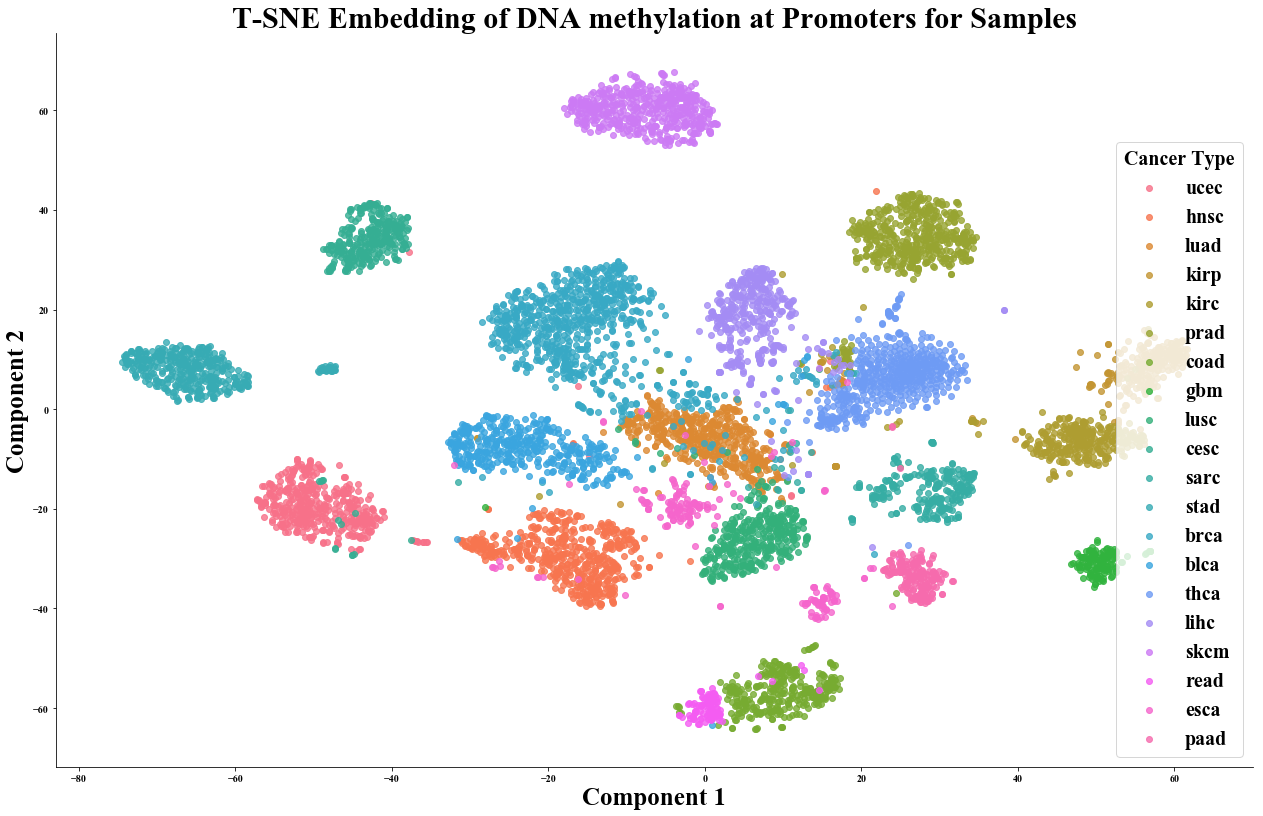

In [25]:
long = pd.DataFrame(embedding, columns=['pc1', 'pc2'], index=meth_samplewise.index)
plate = [n.split('|')[0].split('-')[5] for n in meth_samplewise.index if "mean_beta_value_promoter" in n]
cancer_type = [n.split('|')[1] for n in meth_samplewise.index if "mean_beta_value_promoter" in n]
long['plate'] = plate
long['cancertype'] = cancer_type
g = sns.lmplot(x='pc1', y='pc2', data=long, hue='cancertype', fit_reg=False, legend=False)
g.fig.set_size_inches(20, 12)
g.ax.set_xlabel('Component 1', fontsize=25)
g.ax.set_ylabel('Component 2', fontsize=25)
g.ax.legend(loc='lower right', fontsize=20, title='Cancer Type')
plt.setp(g.ax.get_legend().get_title(), fontsize=20)
plt.title('T-SNE Embedding of DNA methylation at Promoters for Samples', fontsize=30)
g.fig.savefig('../../data/pancancer/TCGA/methylation/tsne_tumortypes.png', dpi=300)